**Градиентный спуск**

Среднеквадратичная ошибка имеет один минимум и непрерывна на всей области значений (то есть является выпуклой и гладкой), а значит в каждой ее точке можно посчитать частные производные.

Вспомним, что _градиентом_ функции $f$ называется $n$-мерный вектор из частных производных. 

$$ \nabla f(x_{1},...,x_{d}) = \left(\frac{\partial f}{\partial x_{i}}\right)^{d}_{i=1}.$$

При этом известно, что __градиент задает направление наискорейшего роста функции__. Значит, антиградиент будет показывать направление её скорейшего убывания, что будет полезно в задаче минимизации функционала ошибки.

Для решения задачи требуется определить некоторую стартовую точку и итерационно сдвигаться от неё в сторону антиградиента с определенным _шагом_ $\eta_{k}$, на каждом шаге пересчитывая градиент в точке, в которой мы находимся. Таким образом, имея начальный вектор весов $w^{0}$, $k$-й шаг градиентного спуска будет иметь вид

$$w^{k} = w^{k-1} - \eta_{k}\nabla Q(w^{k-1}, X).$$

Итерации следует продолжать, пока не наступает сходимость. Она определяется разными способами, но в даннном случае удобно определять как ситуацию, когда векторы весов от шага к шагу изменяются незначительно, то есть норма отклонения вектора весов на текущем шаге от предыдущего не привышает заданное значение $\varepsilon$:

$$||w^{k}-w^{k-1}|| < \varepsilon.$$

Начальный вектор весов $w_{0}$ также можно определять различными способами, обычно его берут нулевым или состоящим из случайных небольших чисел.

В случае многомерной регрессии (при количестве признаков больше 1) при оптимизации функционала ошибки 

$$Q(w, X) = \frac{1}{l}||Xw-y||^{2}\rightarrow \underset{w}{\text{min}}$$

формула вычисления градиента принимает вид

$$\nabla_{w}Q(w,X) = \frac{2}{l}X^{T}(Xw-y).$$

Задача линейной регрессии. Предсказание баллов полученных на экзамене.

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Сгенерируем данные
X, Y, coef = datasets.make_regression(n_samples=10000, n_features=2, n_informative=2, n_targets=1, 
                                      noise=5, coef=True, random_state=42)
X[:, 0] *= 20       # Добавим шума в первый признак
display(X, Y, coef)

array([[-11.38296397,   1.59040357],
       [ 14.69755572,   0.49097495],
       [  4.01397389,   1.10623156],
       ...,
       [-37.72257408,   0.13807841],
       [-20.31757654,  -0.9933587 ],
       [ 23.15039212,   0.54658973]])

array([ -49.6854239 ,   73.63062887,   20.15499442, ..., -192.63317609,
       -106.45952324,  118.37024675])

array([98.57676058,  5.56663928])

In [3]:
X.shape

(10000, 2)

In [4]:
Y.shape

(10000,)

In [5]:
def show_data(X, Y):  
  fig = plt.figure(figsize=(15,15))
  ax = fig.add_subplot(111, projection='3d')

  ax.scatter(X[:, 0], X[:, 1], Y)

  ax.set_xlabel('X0')
  ax.set_ylabel('X1')
  ax.set_zlabel('Y')
  plt.show()

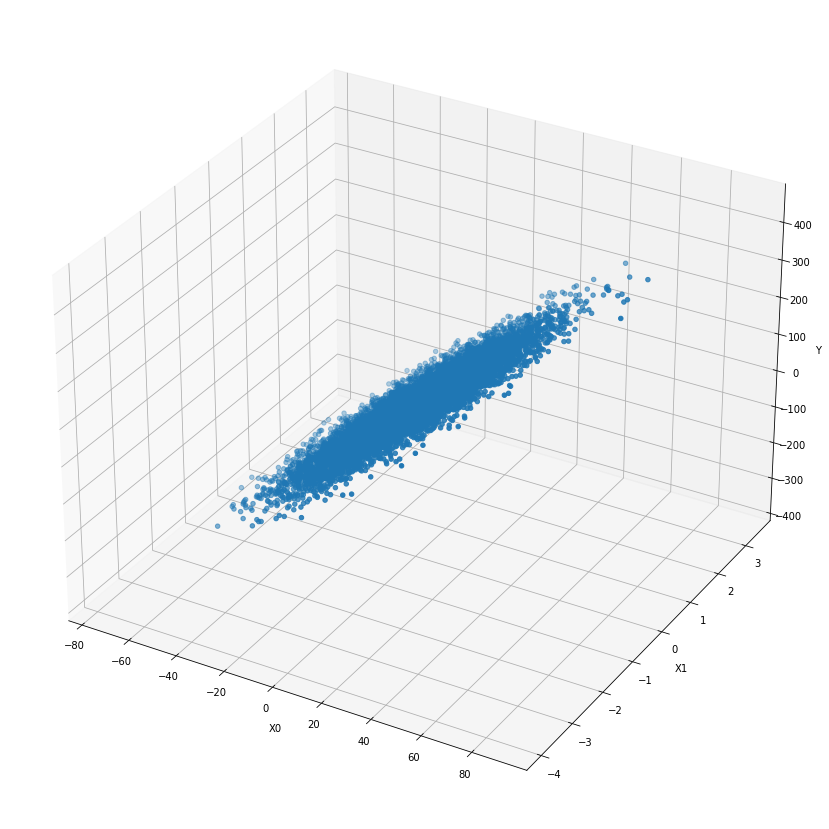

In [6]:
show_data(X, Y)

In [7]:
def standard_scale(X):
  """
  Функция для стандартизации признаков
  """
  return (X - X.mean()) / X.std()

In [8]:
def get_standard_scale(X):
  X_st = X.copy().astype(np.float64)

  for i in range(X_st.shape[1]):
    X_st[:, i] = standard_scale(X_st[:, i])
  return X_st

In [9]:
X_st = get_standard_scale(X)

In [10]:
def get_mse(y, y_pred):
  """
  Вычисление MSE
  """
  error = np.mean((y - y_pred)**2)
  return error

In [11]:
def simple_gradient_descent(X, y, iterations, eta):
  """
  Классический градиентный спуск (GD)
  """
  W = np.random.randn(X.shape[1])
  n = X.shape[0]
  errors = []
  
  for i in range(iterations):
    y_pred = np.dot(X, W)
    err = get_mse(y, y_pred)
    errors.append(err)
    # градиент функции ошибки
    dQ = 2/n * X.T @ (y_pred - y)
    W -= eta * dQ
    if i % 100 == 0:
      print(f'Iter {i}: weights {W} error {err}')
  print(f'\nFinal MSE: {err:.6f}\n')

In [12]:
def gradient_descent(X, y, eta):
  """
  Классический градиентный спуск (GD) с остановкой по сходимости весов
  """
  W = np.random.randn(X.shape[1])
  W_init = W.copy()
  n = X.shape[0]

  # Список значений ошибок после каждой итерации
  errors = []

  # Список значений весов после каждой итерации
  W_list = []

  # Начальная разница весов
  weight_dist = np.inf

  # Критерий сходимости (разница весов, при которой алгоритм останавливается)
  min_weight_dist = 1e-6

  # Счётчик итераций
  iter_num = 0

  print(f'Number of objects = {n} \
      \nLearning rate = {eta} \
      \nInitial weights = {W} \n')
  
  while weight_dist > min_weight_dist:

    y_pred = np.dot(X, W)
    err = get_mse(y, y_pred)
    errors.append(err)

    # Вычисляем градиент функции ошибки  
    dQ = 2/n * X.T @ (y_pred - y)        
    new_W = W - eta * dQ

    # Вычисляем расстояние между весами по норме Эвклида 
    weight_dist = np.linalg.norm(new_W - W, ord=2)

    # Логирование процесса
    if iter_num % 100 == 0:
      print(f'Iteration {iter_num}: weights {W} error {err}')

    iter_num += 1
    W = new_W.copy()
    W_list.append(W)
  
  print(f'\nFinal MSE: {err:.6f}')
  print(f'Number of iterations: {iter_num}\n')
  W_list = np.array(W_list)

  return W_list, errors, iter_num, W_init

In [13]:
# Стохастический градиентный спуск (SGD)
def stohastic_gradient_descent(X, y, size, eta):
  """
  Стохастический градиентный спуск (SGD) с остановкой по сходимости весов
  """
  W = np.random.randn(X.shape[1])
  W_init = W.copy()
  n = X.shape[0]

  # Список значений ошибок после каждой итерации
  errors = []

  # Список значений весов после каждой итерации
  W_list = []

  # Начальная разница весов
  weight_dist = np.inf

  # Критерий сходимости (разница весов, при которой алгоритм останавливается)
  min_weight_dist = 1e-3

  # Счётчик итераций
  iter_num = 0

  print(f'Number of objects = {n} \
      \nLearning rate = {eta} \
      \nInitial weights = {W} \n')
  
  while weight_dist > min_weight_dist:
    
    inds = np.random.randint(n, size=size)
    y_pred = np.dot(X[inds], W)
    err = get_mse(y, np.dot(X, W))
    errors.append(err)

    dQ = 2 / y[inds].shape[0] * X[inds].T @ (y_pred - y[inds]) # градиент функции ошибки
    new_W = W - eta * dQ

    # Вычисляем расстояние между весами по норме Эвклида 
    weight_dist = np.linalg.norm(new_W - W, ord=1)
    
    # Логирование процесса
    if iter_num % 100 == 0:
      print(f'Iteration {iter_num}: weights {W} error {err}')
    
    iter_num += 1
    W = new_W.copy()
    W_list.append(W)
  
  print(f'\nFinal MSE: {err:.6f}')
  print(f'Number of iterations: {iter_num}\n')
  W_list = np.array(W_list)

  return W_list, errors, iter_num, W_init

In [14]:
%%time
simple_gradient_descent(X_st, Y, iterations=2000, eta=1e-2)

Iter 0: weights [2.23079731 0.33568   ] error 9585.533082476853
Iter 100: weights [85.22883305  4.8370995 ] error 193.49976678780962
Iter 200: weights [96.24019458  5.50708986] error 28.06519895970553
Iter 300: weights [97.70113754  5.60563069] error 25.15067110066909
Iter 400: weights [97.89497804  5.61998439] error 25.09931580642834
Iter 500: weights [97.92069826  5.62205851] error 25.098410747166096
Iter 600: weights [97.92411117  5.6223562 ] error 25.098394794131913
Iter 700: weights [97.92456405  5.62239869] error 25.09839451288761
Iter 800: weights [97.92462416  5.62240472] error 25.098394507928564
Iter 900: weights [97.92463213  5.62240557] error 25.098394507841107
Iter 1000: weights [97.92463319  5.62240569] error 25.098394507839565
Iter 1100: weights [97.92463333  5.62240571] error 25.098394507839537
Iter 1200: weights [97.92463335  5.62240571] error 25.098394507839537
Iter 1300: weights [97.92463335  5.62240571] error 25.09839450783954
Iter 1400: weights [97.92463335  5.62240

In [15]:
%%time
W_list_gd, err_gd, iter_gd, W_init_gd = gradient_descent(X_st, Y, eta=1e-2)

Number of objects = 10000       
Learning rate = 0.01       
Initial weights = [ 0.73263126 -1.25584696] 

Iteration 0: weights [ 0.73263126 -1.25584696] error 9514.349065650234
Iteration 100: weights [85.02874278  4.62470959] error 192.31416261632688
Iteration 200: weights [96.21347131  5.4787462 ] error 28.04551037363619
Iteration 300: weights [97.6975685   5.60184818] error 25.150345226017592
Iteration 400: weights [97.89450138  5.61947961] error 25.099310432873498
Iteration 500: weights [97.9206346   5.62199114] error 25.098410658934583
Iteration 600: weights [97.92410266  5.62234721] error 25.098394792690243
Iteration 700: weights [97.92456292  5.62239749] error 25.098394512864186

Final MSE: 25.098395
Number of iterations: 719

CPU times: user 193 ms, sys: 225 ms, total: 418 ms
Wall time: 417 ms


In [16]:
print(W_list_gd)

[[ 2.67602425 -1.12459885]
 [ 4.58055791 -0.99584941]
 [ 6.44700927 -0.86955116]
 ...
 [97.92458339  5.62239982]
 [97.92458438  5.62239994]
 [97.92458536  5.62240005]]


In [30]:
%%time
W_list_sgd, err_sgd, iter_sgd, W_init_sgd  = stohastic_gradient_descent(X_st, Y, size=1, eta=1e-2)

Number of objects = 10000       
Learning rate = 0.01       
Initial weights = [-1.87604794  0.93755553] 

Iteration 0: weights [-1.87604794  0.93755553] error 10004.183372348496
Iteration 100: weights [80.92285249  5.56742421] error 314.1558943917993

Final MSE: 73.334934
Number of iterations: 139

CPU times: user 34.9 ms, sys: 34.3 ms, total: 69.2 ms
Wall time: 47 ms


In [18]:
def visualization_mse(iter_gd, iter_sgd, err_gd, err_sgd):
  """
  Функция визуализации изменения ошибки после каждой итерации для GD и SGD
  """
  plt.figure(figsize=(14, 10))
  plt.plot(range(iter_gd), err_gd, color='b', label='GD', alpha=0.8)
  plt.plot(range(iter_sgd), err_sgd, color='r',label='SGD', alpha=0.8)
  plt.title('Зависимость MSE от количества итераций')
  plt.xlabel('Число итераций')
  plt.ylabel('MSE')
  plt.xlim(0, 200)
  plt.legend()

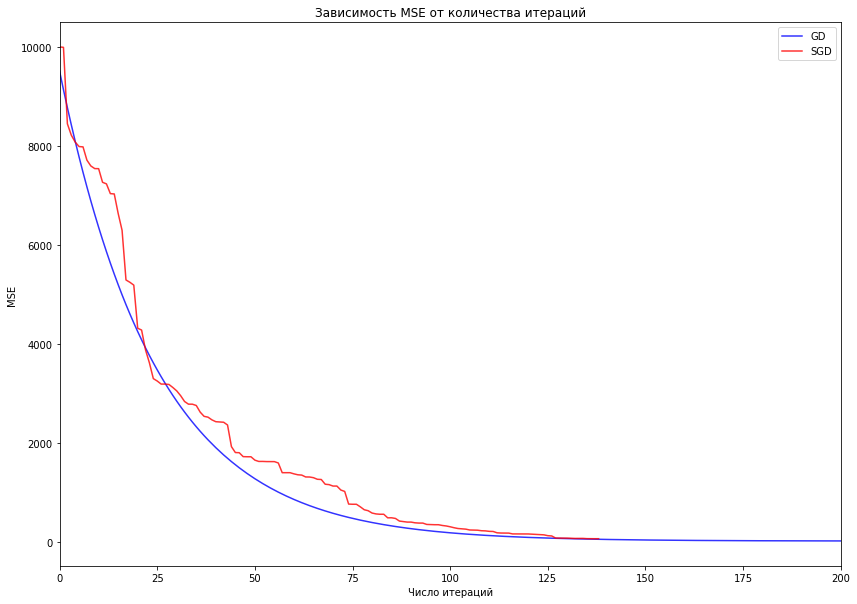

In [31]:
visualization_mse(iter_gd, iter_sgd, err_gd, err_sgd)

In [20]:
def visualization_weigths(W_init_gd, W_init_sgd, W_list_gd, W_list_sgd):
  """
  Функция визуализации изменения весов для GD и SGD
  """
  plt.figure(figsize=(25, 10))
  plt.title('Изменение весов')
  plt.xlabel(r'$w_1$')
  plt.ylabel(r'$w_2$')

  # Красной точкой обозначены веса, сгенерированные в начале алгоритма
  plt.scatter(W_init_gd[0], W_init_gd[1], c='r')
  plt.scatter(W_init_sgd[0], W_init_sgd[1], c='r')

  # Веса для GD
  plt.scatter(W_list_gd[:, 0], W_list_gd[:, 1])
  plt.plot(W_list_gd[:, 0], W_list_gd[:, 1], label='GD')

  # Веса для SGD
  plt.scatter(W_list_sgd[:, 0], W_list_sgd[:, 1])
  plt.plot(W_list_sgd[:, 0], W_list_sgd[:, 1], label='SGD')

  plt.legend(loc='upper left')
  plt.show()

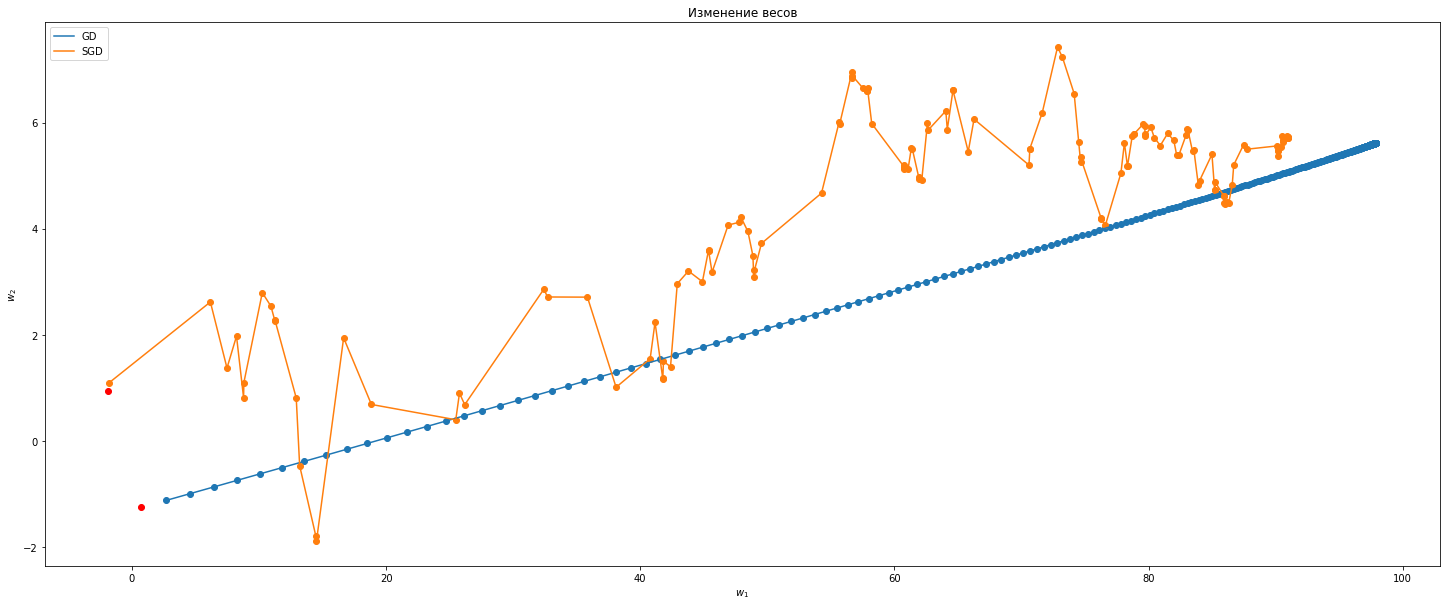

In [32]:
visualization_weigths(W_init_gd, W_init_sgd, W_list_gd, W_list_sgd)

In [22]:
reg = make_pipeline(StandardScaler(), 
                    SGDRegressor(max_iter=1000, tol=1e-3))

In [23]:
reg.fit(X, Y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor', SGDRegressor())])

In [26]:
pred = reg.predict(X)
pred

array([ -47.24670212,   75.19738003,   25.96880906, ..., -185.34906561,
       -105.8766209 ,  117.203672  ])

In [25]:
reg.score(X, Y)

0.9974508666372033